#### Imports

In [11]:
import sys
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus

movies = pd.read_csv('./dataset/movies.csv')

#### Preprocessing

In [12]:
movies.dropna(inplace=True, subset=['description'])

# Custom tokenizer function
def remove_numbers_and_roman_numerals(text):
    number_pattern = r'\b\d+\b'
    roman_pattern = r'\bM{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})\b'
    text = re.sub(number_pattern, '', text)
    text = re.sub(roman_pattern, '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

def custom_tokenizer(text):
    text = remove_numbers_and_roman_numerals(text)
    tokens = text.split()
    return tokens

custom_stop_words = {'lives', 'life', 'director', 'directed', 'film', 'films', 'filmaker',}
combined_stop_words = list(ENGLISH_STOP_WORDS.union(custom_stop_words))

# Tokenizing descriptions for dictionary
tokenized_descriptions = [doc.split() for doc in movies['description']]

# Remove stop words and vectorize to bag of words
vectorizer = CountVectorizer(tokenizer=custom_tokenizer, stop_words=combined_stop_words, min_df=100, max_df=0.06)
X = vectorizer.fit_transform(movies['description'])
vocab = vectorizer.get_feature_names_out()

# Convert sparse matrix to Gensim's corpus
corpus = Sparse2Corpus(X, documents_columns=False)
id2word = Dictionary(tokenized_descriptions)

# Normalize data
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x102c82d30>>
Traceback (most recent call last):
  File "/Users/biboy/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
/Users/biboy/Library/Python/3.9/lib/python/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


##### Determining Range of Topics for LDA using Log Likelihoods

In [ ]:
# log_likelihoods = []
# n_topics_options = range(5, 31)  # Trying from 5 to 30 topics
# for n_topics in n_topics_options:
#     print("Starting LDA", n_topics)
#     lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
#     print("Model insantiated")
#     lda.fit(X_normalized)
#     print("Model fitted")
#     ldaScore = lda.score(X_normalized)
#     log_likelihoods.append(ldaScore)
#     print("LDA", n_topics, ":", ldaScore)

# # Plot log likelihoods
# plt.figure(figsize=(12, 6))
# plt.plot(n_topics_options, log_likelihoods, marker='o')
# plt.xlabel('Number of Topics')
# plt.ylabel('Log Likelihood')
# plt.title('Log Likelihood by Number of Topics')
# plt.show()

##### Determining Model with highest Coherence score from range of Topics

In [ ]:
n_topics = 6

print("Starting", n_topics)
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=n_topics, passes=10, random_state=0)
print("Model instantiated")

# Calculate coherence score
cm = CoherenceModel(model=lda_model, texts=tokenized_descriptions, dictionary=id2word, coherence='c_v')
coherence = cm.get_coherence()
print("LDA", n_topics, ":", coherence)

# Print top words per topic
def print_top_words(model):
    for idx, topic in model.print_topics(-1):
        print(f"Topic #{idx}: {topic}")

print("Top words per topic:")
print_top_words(lda_model)

In [ ]:
# Select the model with the highest coherence score

def convert_lda_output_to_matrix(lda_output, num_topics):
    matrix = np.zeros((len(lda_output), num_topics))
    for i, doc in enumerate(lda_output):
        for topic, prob in doc:
            matrix[i, topic] = prob
    return matrix

lda_output = lda_model.get_document_topics(corpus, minimum_probability=0)

lda2d = convert_lda_output_to_matrix(lda_output, n_topics)

#### Fitting to K-means Model and Determining Optimal Clusters

In [ ]:
# silhouette_scores = []
# inertia_scores = []
# for k in range(2, 11):
#     kmeans = KMeans(n_clusters=k, random_state=0)
#     kmeans.fit(lda2d)
#     score = silhouette_score(lda2d, kmeans.labels_)
#     inertia = kmeans.inertia_
#     inertia_scores.append(inertia)
#     silhouette_scores.append(score)

# # Plot silhouette scores
# plt.figure(figsize=(12, 6))
# plt.plot(range(2, 11), silhouette_scores, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score vs Number of Clusters')
# plt.show()

# # Plot silhouette scores
# plt.figure(figsize=(12, 6))
# plt.plot(range(2, 11), inertia_scores, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score vs Number of Clusters')
# plt.show()

# Select the optimal number of clusters
optimal_clusters = 18
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=0)
kmeans_final.fit(lda2d)

KMeans(n_clusters=18, random_state=0)

#### Results and Plots

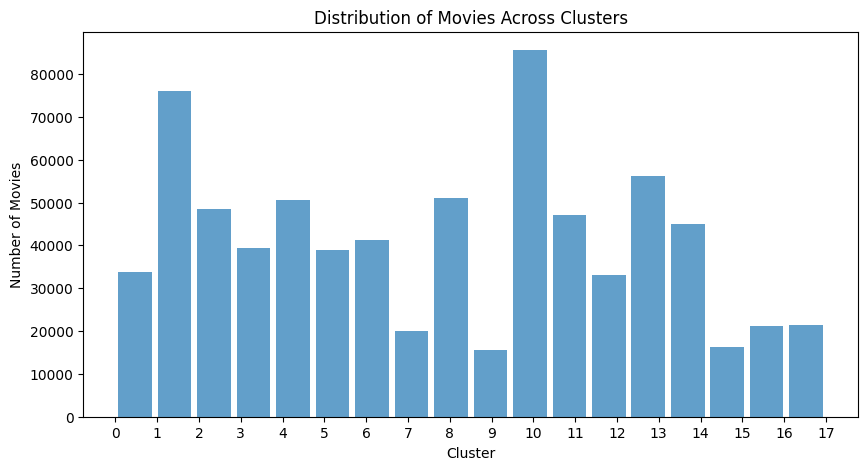

In [ ]:
movies['cluster'] = kmeans_final.labels_

# Plot clusters
plt.figure(figsize=(10, 5))
plt.hist(movies['cluster'], bins=optimal_clusters, alpha=0.7, rwidth=0.85)
plt.xlabel('Cluster')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies Across Clusters')
plt.xticks(range(optimal_clusters))
plt.show()

In [ ]:
def print_top_words_and_movies_per_cluster(kmeans, feature_names, movies, top_x):
    for cluster in range(kmeans.n_clusters):
        print(f"Cluster {cluster}:")
        
        # Print top words
        cluster_center = kmeans.cluster_centers_[cluster]
        top_word_indices = cluster_center.argsort()[:-top_x - 1:-1]
        top_words = [feature_names[i] for i in top_word_indices]
        print("Top words:", ", ".join(top_words))
        
        # Print top movies
        cluster_movies = movies[movies['cluster'] == cluster]
        top_movies = cluster_movies.nlargest(top_x, 'rating')[['name', 'rating']]
        print("Top movies:")
        for idx, row in top_movies.iterrows():
            print(f"Title: {row['name']}, Rating: {row['rating']}")
        
        print("\n")

# Print the top 10 words and top 10 movies in each cluster
print_top_words_and_movies_per_cluster(kmeans_final, vocab, movies, top_x=10)

Cluster 0:
Top words: "all, ",, !, "., "a, "
Top movies:
Title: Band of Brothers, Rating: 4.68
Title: Planet Earth, Rating: 4.57
Title: Shoah, Rating: 4.49
Title: Cosmos: A Personal Voyage, Rating: 4.48
Title: The Vietnam War, Rating: 4.43
Title: Mario Puzo's The Godfather: The Complete Novel for Television, Rating: 4.41
Title: The Beatles: Get Back - The Rooftop Concert, Rating: 4.39
Title: James Acaster: Cold Lasagne Hate Myself 1999, Rating: 4.39
Title: Baseball, Rating: 4.38
Title: Tie Xi Qu: West of the Tracks, Rating: 4.37


Cluster 1:
Top words: !, "a, ", "., ",, "all
Top movies:
Title: Yi Yi, Rating: 4.53
Title: City of God, Rating: 4.52
Title: Ikiru, Rating: 4.51
Title: GoodFellas, Rating: 4.48
Title: Autumn Sonata, Rating: 4.44
Title: Spider-Man: Into the Spider-Verse, Rating: 4.43
Title: Tokyo Story, Rating: 4.43
Title: Persona, Rating: 4.42
Title: Mishima: A Life in Four Chapters, Rating: 4.41
Title: Paris, Texas, Rating: 4.4


Cluster 2:
Top words: !, "a, ",, ", "., "all
T